In [47]:
import matplotlib.pyplot as plt

In [56]:
%cd "C://Users//TRETEC//Documents//MVA//S1//[IPGM] Introduction to probabilistic graphical models//Projet//independent_component_analysis"
from mva_independent_component_analysis.utils.preprocessing import centering_and_whitening
from mva_independent_component_analysis.fast_ica.fastica import fast_ica as fastica
from mva_independent_component_analysis.fast_ica.discriminating_fastica import fast_ica as discriminating_fastica
from mva_independent_component_analysis.mle_ica.gradient import gradient_ica
%cd experiments

C:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis
C:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis\experiments


c:\Users\TRETEC\Documents\MVA\S1\[IPGM] Introduction to probabilistic graphical models\Projet\independent_component_analysis\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [57]:
s1_file = "data/chopin-fantaisie-impromptu-op.wav"
s2_file = "data/scorch-fire.wav"

In [59]:
import numpy as np
np.random.seed(0)

from scipy.io import wavfile as wf

def mix_sources(sources, apply_noise=False):
    # Mixing process
    A = np.array([[0.8, 0.3],
              [0.4, 0.5]])

    # Mixed signals
    X = A @ sources
        
    return X

sampling_rate_1, s1 = wf.read(s1_file)
s1 = s1[:,0]

sampling_rate_2, s2 = wf.read(s2_file)
s2 = s2[:,0]
print(s1.shape, s2.shape)

(12390918,) (1554726,)


C:\Users\TRETEC\AppData\Local\Temp\ipykernel_1328\3374866529.py:16: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate_1, s1 = wf.read(s1_file)
C:\Users\TRETEC\AppData\Local\Temp\ipykernel_1328\3374866529.py:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate_2, s2 = wf.read(s2_file)


In [60]:
x = mix_sources([s1[:s2.shape[0]], s2], False)
print(f'Shape of s1: {s1.shape}, s2: {s2.shape}, Linear Mix: {x.shape}')
wf.write('./talk_and_music.wav', sampling_rate_2, x.mean(axis=0).astype(np.float32))

Shape of s1: (12390918,), s2: (1554726,), Linear Mix: (2, 1554726)


In [70]:
# Center & whiten signals
X, meanX, whiteM = centering_and_whitening(x)

In [64]:
def fastIcaNour(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape #(m,n)

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy() #(1,p)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            while (i < iterations):

                # Dot product of weight and signal
                wTx = np.dot(w, signals) # (1,p)(p,n)=(1,n)

                # Pass w*s into contrast function g
                gwTx = np.tanh(wTx * alpha).T #(n,1)

                # Pass w*s into g prime
                g_wTx = (1 - np.square(np.tanh(wTx))) * alpha #(n,1)

                # Update weights
                w_ = (signals * gwTx.T).mean(axis=1) - g_wTx.mean() * w.squeeze()

                # Decorrelate weights
                w_ = w_ - np.dot(np.dot(w_, W[:c].T), W[:c])

                # Normalize
                w_ = w_ / np.sqrt((w_ ** 2).sum())

                w_ /= np.linalg.norm(w_)

                if np.abs(np.abs(w_.T@w) - 1) < thresh:
                  break

                # Update weights
                w = w_

                # Update counter
                i += 1

            W[c, :] = w
    return W

In [65]:
S=np.array([s1[:s2.shape[0]], s2])

In [75]:
import jax
import jax.numpy as jnp

JAX_KEY = jax.random.PRNGKey(0)
W_fastIca = fastica(JAX_KEY, X, X.shape[0], 1e-8, jnp.tanh, 5000)  #Yvann's method
unMixed = np.dot(W_fastIca,X)
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18,1])
ax.plot(S.T)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals')
ax.set_xlim(0, S.shape[1])  #ns[-1] depends


def plot_recovered_signals(unMixed):
    fig, ax = plt.subplots(1, 1, figsize=[18,1])
    ax.plot((unMixed).T, label='Recovered signals')
    ax.set_xlabel('Sample number')
    ax.set_title('Recovered signals')
    ax.set_xlim(0, S.shape[1])

    Sw, _, _ = centering_and_whitening(S)

    for i in range(2):
        perm = np.argmax(np.abs(unMixed[i,:] @ Sw.T))
        plt.figure(figsize=(18,3))
        plt.subplot(3,1,i+1)
        plt.plot(unMixed[i,:].T)
        plt.plot(S[perm].T)
        plt.xlim(0, S.shape[1])
        plt.show()
    # ax.set_ylim(-1.5, 1.5)


print(f"fastIca")
plot_recovered_signals(unMixed)

ValueError: Incompatible shapes for broadcasting: shapes=[(2, 1554726), (2,)]

fastIca Nour


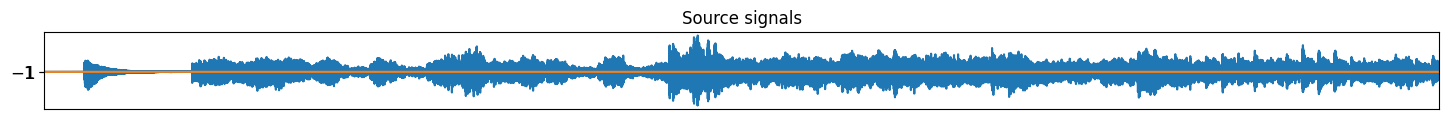

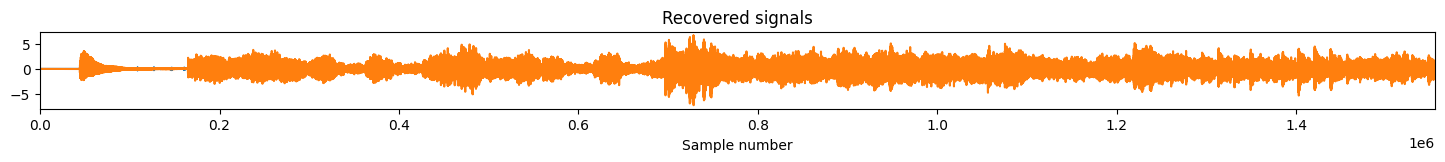

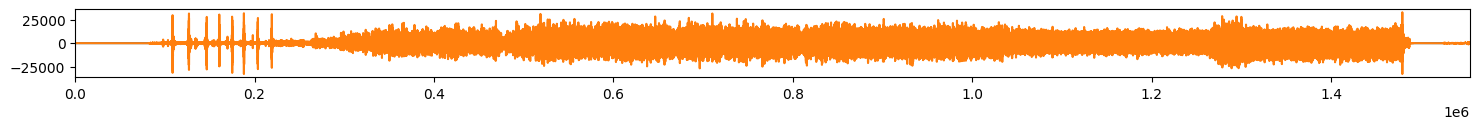

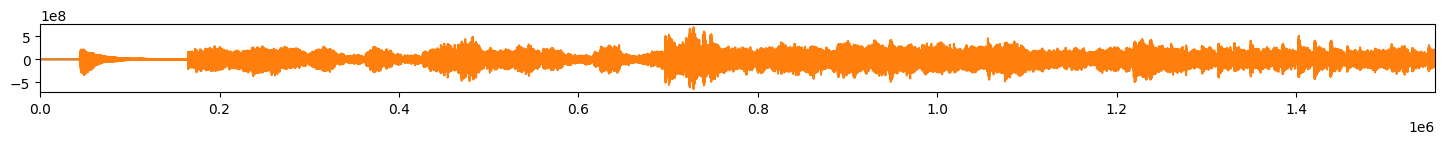

In [66]:
W_fastIcaNour = fastIcaNour(X, 1, 1e-8, 5000) #Nour's method.
unMixed = np.dot(W_fastIcaNour,X)
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18,1])
ax.plot(S.T)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals')
ax.set_xlim(0, S.shape[1])  #ns[-1] depends


def plot_recovered_signals(unMixed):
    fig, ax = plt.subplots(1, 1, figsize=[18,1])
    ax.plot((unMixed).T, label='Recovered signals')
    ax.set_xlabel('Sample number')
    ax.set_title('Recovered signals')
    ax.set_xlim(0, S.shape[1])

    Sw, _, _ = centering_and_whitening(S)

    for i in range(2):
        perm = np.argmax(np.abs(unMixed[i,:] @ Sw.T))
        plt.figure(figsize=(18,3))
        plt.subplot(3,1,i+1)
        plt.plot(unMixed[i,:].T)
        plt.plot(S[perm].T)
        plt.xlim(0, S.shape[1])
        plt.show()
    # ax.set_ylim(-1.5, 1.5)


print(f"fastIca Nour")
plot_recovered_signals(unMixed)

In [68]:
wf.write('inference/s1_predicted.wav', sampling_rate_2, unMixed[0].astype(np.float32))
wf.write('inference/s2_predicted.wav', sampling_rate_2, unMixed[1].astype(np.float32))